In [26]:
from matplotlib.collections import EllipseCollection

from ellipse_rcnn.utils.conics import (
    ellipse_to_conic_matrix,
    conic_center,
)

from ellipse_rcnn.utils.data.fddb import FDDB

In [27]:
from ellipse_rcnn import EllipseRCNN
from ellipse_rcnn.core.model import EllipseRCNNLightning
import torch

In [28]:
model = EllipseRCNN()

In [29]:
pl_model = EllipseRCNNLightning.load_from_checkpoint(
    "../checkpoints/e=08-loss=1.78192.ckpt", model=model
)

In [30]:
model.eval().cpu()

EllipseRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(256,), max_size=512, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [31]:
ds = FDDB("../data/FDDB")
ds_raw = FDDB("../data/FDDB", transform=lambda x: x)

(399, 450)
[{'boxes': tensor([[2.0670e+02, 8.0104e+01, 3.2128e+02, 2.5165e+02],
        [3.9052e+02, 2.1353e+02, 4.3912e+02, 2.9399e+02],
        [3.2520e+01, 2.4758e+02, 7.1378e+01, 2.9849e+02],
        [1.1444e+01, 2.5152e+02, 3.9248e+01, 2.9358e+02],
        [7.6308e+01, 2.4372e+02, 1.0856e+02, 2.7551e+02],
        [2.2588e+01, 2.2200e+02, 8.1219e+01, 3.0620e+02],
        [4.2569e+01, 2.5850e+02, 6.6945e+01, 2.9179e+02],
        [3.8595e+01, 2.3826e+02, 8.3131e+01, 2.9194e+02],
        [7.2896e+00, 2.5625e+02, 2.9379e+01, 2.8662e+02],
        [2.7341e+01, 2.5359e+02, 5.5588e+01, 2.9485e+02],
        [4.2565e+02, 2.2425e+02, 4.4781e+02, 2.8929e+02],
        [7.2210e+01, 2.4083e+02, 9.5978e+01, 2.7830e+02],
        [1.0442e+01, 2.3771e+02, 5.5143e+01, 3.0316e+02],
        [6.4478e+01, 2.2851e+02, 1.1009e+02, 2.8360e+02],
        [1.8844e+01, 2.5325e+02, 4.6906e+01, 2.8835e+02],
        [4.7158e+01, 2.6365e+02, 7.5067e+01, 2.9518e+02],
        [6.0086e+01, 2.4510e+02, 8.5631e+01, 2.809

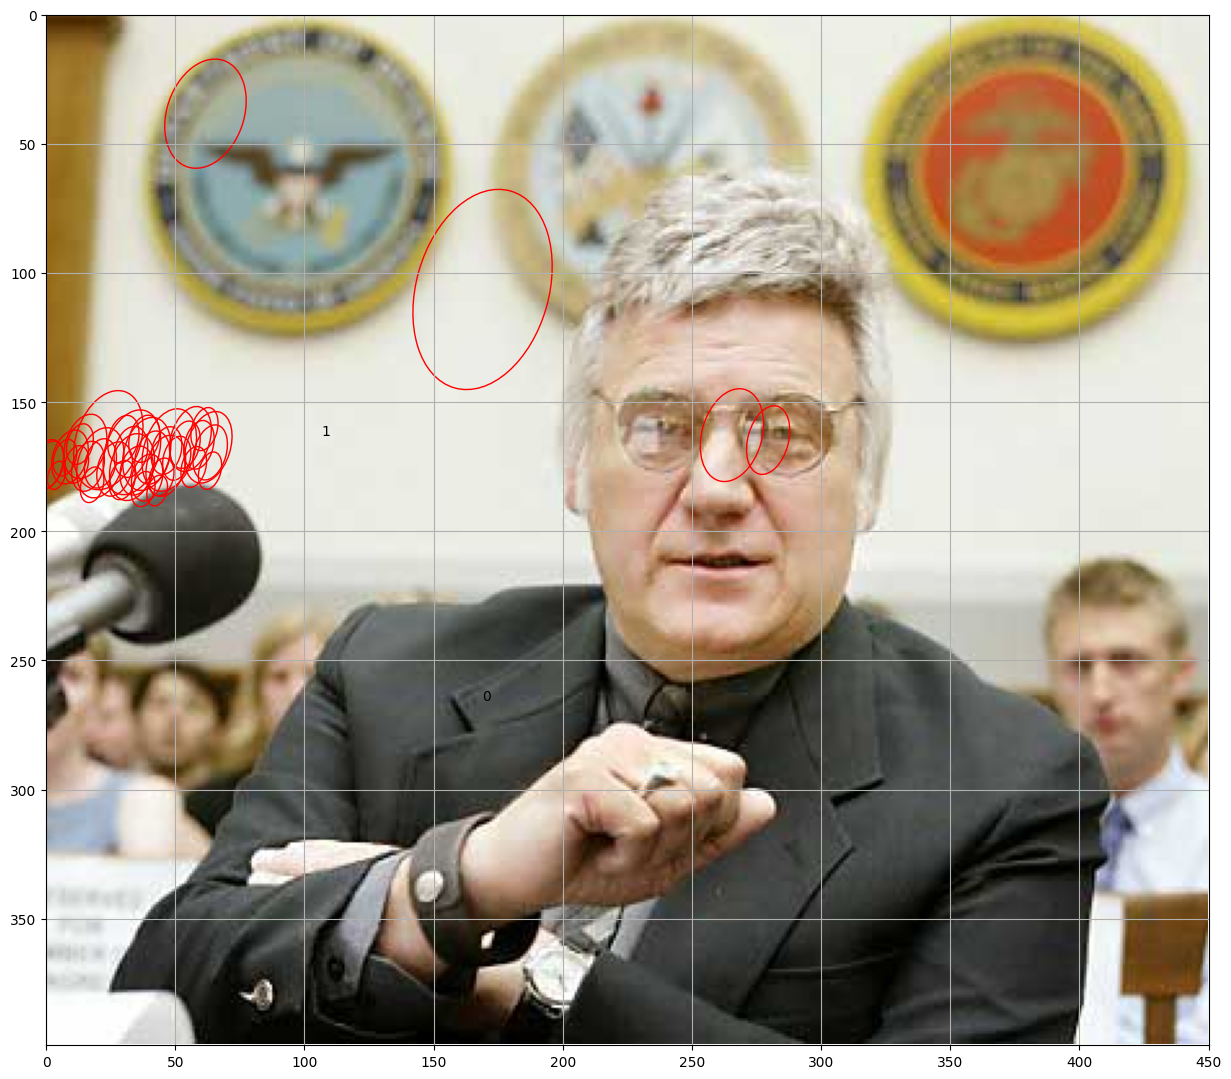

In [48]:
from matplotlib.axes import Axes
from matplotlib.collections import EllipseCollection
from matplotlib import pyplot as plt
from ellipse_rcnn.utils.conics import ellipse_axes, ellipse_angle
import numpy as np


def plot_conics(
        A_craters: torch.Tensor,
        resolution: tuple[int, int],
        figsize: tuple[float, float] = (15, 15),
        plot_centers: bool = False,
        ax: Axes | None = None,
        rim_color='r',
        alpha=1.):

    a_proj, b_proj = ellipse_axes(A_craters)
    psi_proj = ellipse_angle(A_craters)
    x_pix_proj, y_pix_proj = conic_center(A_craters)

    a_proj, b_proj, psi_proj, x_pix_proj, y_pix_proj = map(
        lambda t: t.detach().cpu().numpy(),
        (a_proj, b_proj, psi_proj, x_pix_proj, y_pix_proj)
    )

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize, subplot_kw={'aspect': 'equal'})

    # Set axes according to camera pixel space convention
    ax.set_xlim(0, resolution[0])
    ax.set_ylim(resolution[1], 0)

    ec = EllipseCollection(a_proj, b_proj, np.degrees(psi_proj), units='xy', offsets=np.column_stack((x_pix_proj, y_pix_proj)),
                           transOffset=ax.transData, facecolors="None", edgecolors=rim_color, alpha=alpha)
    ax.add_collection(ec)

    if plot_centers:
        crater_centers = conic_center(A_craters)
        for k, c_i in enumerate(crater_centers):
            x, y = c_i[0], c_i[1]
            if 0 <= x <= resolution[0] and 0 <= y <= resolution[1]:
                ax.text(x, y, str(k))


i = 90

image, target_dict = ds[i]
image_raw, _ = ds_raw[i]

resolution = tuple(image.shape[-2:])
print(resolution)
# Save or display the image
pred = model(image.unsqueeze(0))
if len(pred[0]["boxes"]) > 0:
    print(pred)
    fig, ax = plt.subplots(1, figsize=(15, 25))
    ax.set_aspect("equal")
    ax.grid(True)
    ax.imshow(np.array(image_raw))
    a, b, x, y, theta = map(lambda t: t.transpose(-1, 0).detach(), pred[0]["ellipse_matrices"])

    A_pred = ellipse_to_conic_matrix(a=a, b=b, x=x, y=y, theta=theta)
    plot_conics(A_pred, ax=ax, plot_centers=True, resolution=(450, 399))
    plt.show()
